In [88]:
import torch
from matplotlib import image
import numpy
from targets import *
from utils import *

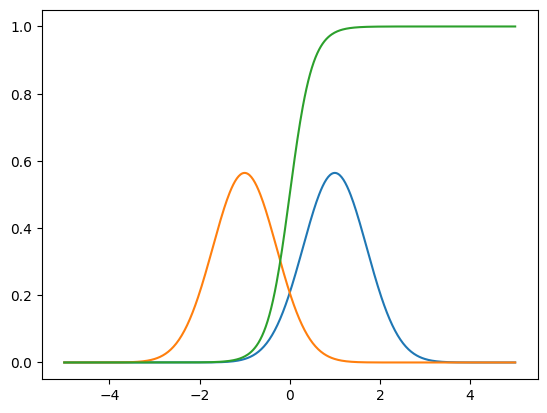

In [89]:
label_1 = torch.distributions.MultivariateNormal(1*torch.ones(1), .5*torch.eye(1))
label_0 = torch.distributions.MultivariateNormal((-1)*torch.ones(1), .5*torch.eye(1))
tt = torch.linspace(-5,5,500)
plt.plot(tt,torch.exp(label_1.log_prob(tt.unsqueeze(-1))).squeeze(-1))
plt.plot(tt,torch.exp(label_0.log_prob(tt.unsqueeze(-1))).squeeze(-1))
plt.plot(tt,(torch.exp(label_1.log_prob(tt.unsqueeze(-1)))/(torch.exp(label_1.log_prob(tt.unsqueeze(-1))) + torch.exp(label_0.log_prob(tt.unsqueeze(-1))))).squeeze(-1))

In [90]:
class BinaryClassifier(torch.nn.Module):
    def __init__(self, label_0_samples, label_1_samples, hidden_dims):
        super().__init__()
        self.label_0_samples = label_0_samples
        self.N_0 = label_0_samples.shape[0]
        self.label_1_samples = label_1_samples
        self.N_1 = label_0_samples.shape[0]
        self.p = label_0_samples.shape[-1]

        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.SiLU(), ])
        network.pop()
        self.logit_r = torch.nn.Sequential(*network)


    def loss(self,label_0_samples,label_1_samples):
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.mean(log_sigmoid(self.logit_r(label_1_samples)))-torch.mean(log_sigmoid(-self.logit_r(label_0_samples)))

    def train(self, epochs, batch_size=None, lr = 5e-3, weight_decay = 5e-6):
        assert self.label_0_samples.shape[0]==self.label_1_samples.shape[0], 'mismatch in number samples'
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay = weight_decay)
        if batch_size is None:
            batch_size = self.label_1_samples.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        dataset = torch.utils.data.TensorDataset(self.label_0_samples.to(device),self.label_1_samples.to(device))

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for batch in dataloader:
                optimizer.zero_grad()
                batch_loss = self.loss(batch[0],batch[1])
                batch_loss.backward()
                optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0],batch[1]) for batch in dataloader]).mean().item()
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + '; device = ' + str(device))
        self.to(torch.device('cpu'))

In [91]:
label_0_samples= label_0.sample([10000])
label_1_samples= label_1.sample([10000])
binary_classif = BinaryClassifier(label_0_samples, label_1_samples,[128,128,128])
binary_classif.train(100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s, loss = 0.385579; device = cuda]


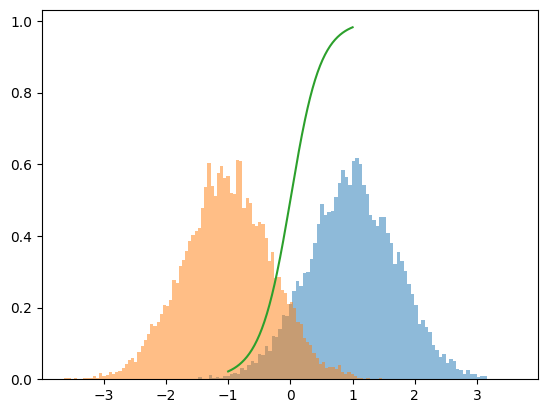

In [86]:
plt.hist(label_1_samples.numpy(), density =True, bins = 100, alpha = .5)
plt.hist(label_0_samples.numpy(), density =True, bins = 100, alpha =.5)
plt.plot(tt, torch.sigmoid(binary_classif.logit_r(tt.unsqueeze(-1))).squeeze(-1).detach().numpy())
plt.show()

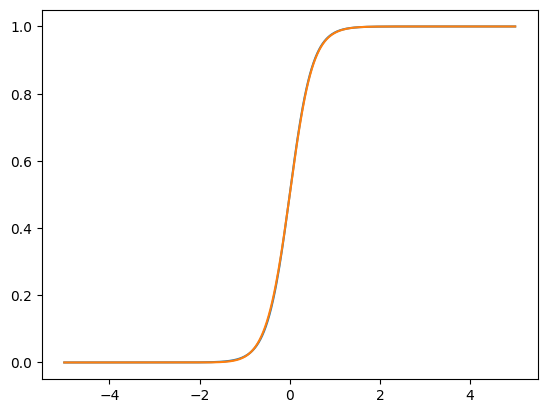

In [92]:
plt.plot(tt,(torch.exp(label_1.log_prob(tt.unsqueeze(-1)))/(torch.exp(label_1.log_prob(tt.unsqueeze(-1))) + torch.exp(label_0.log_prob(tt.unsqueeze(-1))))).squeeze(-1))
plt.plot(tt, torch.sigmoid(binary_classif.logit_r(tt.unsqueeze(-1))).squeeze(-1).detach().numpy())
plt.show()

In [14]:
import torch
from tqdm import tqdm

class Classifier(torch.nn.Module):
    def __init__(self, K, samples, labels, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        assert samples.shape[0] == labels.shape[0],'number of samples does not match number of samples'
        self.samples = samples
        self.labels = labels
        self.p = samples.shape[-1]
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1),torch.nn.Tanh(),])
        self.f = torch.nn.Sequential(*network)

        self.w = torch.distributions.Dirichlet(torch.ones(samples.shape[0])).sample()

    def log_prob(self, samples):
        temp = self.f.forward(samples)
        return temp - torch.logsumexp(temp, dim = -1, keepdim=True)

    def loss(self, samples,labels,w):
        return -torch.sum((self.log_prob(samples)[range(samples.shape[0]), labels]))

    def train(self, epochs,batch_size=None, lr = 5e-3, weight_decay = 5e-5, verbose = False):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay = weight_decay)
        if batch_size is None:
            batch_size = self.samples.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        dataset = torch.utils.data.TensorDataset(self.samples.to(device), self.labels.to(device), self.w.to(device))

        if verbose:
            pbar = tqdm(range(epochs))
        else:
            pbar = range(epochs)
        for _ in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for _,batch in enumerate(dataloader):
                optimizer.zero_grad()
                loss = self.loss(batch[0], batch[1], batch[2])
                loss.backward()
                optimizer.step()
            if verbose:
                with torch.no_grad():
                    iteration_loss = torch.tensor(
                        [self.loss(batch[0], batch[1], batch[2]) for _, batch in
                         enumerate(dataloader)]).sum().item()
                pbar.set_postfix_str('loss = ' + str(round(iteration_loss,4)) + '; device = ' + str(device))
        self.cpu()

In [12]:
samples = torch.cat([target_samples, proposed_samples], dim =0)
labels = torch.cat([torch.ones(num_samples), torch.zeros(num_samples)], dim = 0).long()
binary_classif = Classifier(2,samples, labels, [16,16,16])
binary_classif.train(500,lr = 1e-3, verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:33<00:00,  3.26it/s, loss = 5987.8125; device = cuda]


In [7]:
posterior_log_prob = lambda x: binary_classif.log_prob(x)[:,-1]

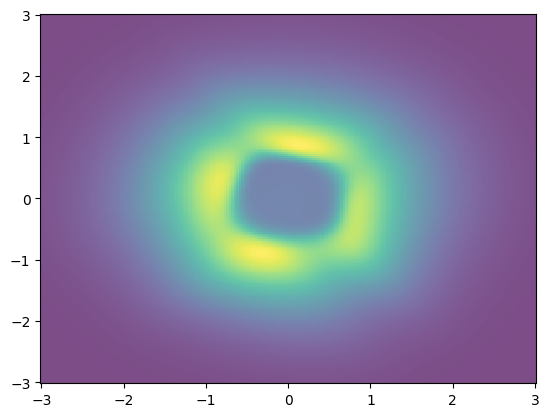

In [8]:
from utils import *
plot_2d_function(lambda x: torch.exp(posterior_log_prob(x) + instrumental.log_prob(x)), bins = [200,200], range = [[-3, 3],[-3,3]])